In [22]:
# Load required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage.color import rgb2lab
from scipy.ndimage import gaussian_filter, label
from PIL import Image
from ipywidgets import interact, FloatSlider, IntSlider
import sys
from pathlib import Path

# Add the parent directory to the Python path
sys.path.append(str(Path.cwd().parent))

%matplotlib inline

# Image Thresholding Techniques

Notebook Objective: The goal of this notebook is to explore and test various thresholding techniques for plant identification in images. Plant detection is a crucial step in applications such as agriculture, environmental monitoring, and vegetation mapping. By segmenting plant regions from background or non-vegetative areas, we can gain insights into plant coverage, health, and distribution.

Why Thresholding? Thresholding is a fundamental image segmentation technique that separates objects of interest based on pixel intensity or color properties. By using appropriate thresholds, we can isolate plant regions effectively. This notebook investigates multiple thresholding methods, ranging from simple color-space-based techniques to more advanced vegetation indices and clustering methods.

What Will We Explore?

1. LAB-Based Thresholding:
    - Leveraging the A channel of the LAB color space to distinguish between green (vegetation) and red (non-vegetation) areas.

2. Vegetation Indices:
    - Utilizing mathematical transformations such as the Excess Green Index (ExG), Green Leaf Index (GLI), and Normalized Difference Index (NDI) to highlight vegetation.

3. Histogram-Based Thresholding:
    - Using Otsu’s method and manual thresholds for binary segmentation.

4. Texture-Based Analysis:
    - Detecting plants based on texture features like edges or local variance.

5. Clustering:
    - Using unsupervised learning techniques like k-means to segment plant regions.

How Will We Compare? Each technique will produce a binary mask indicating plant regions. We will visualize and compare the results to assess the strengths and limitations of each method.

## Load and Display Image


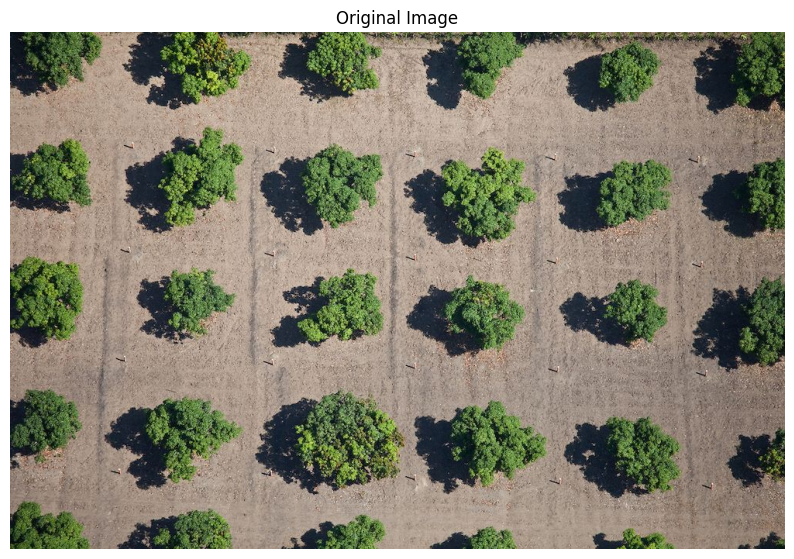

In [23]:
from plant_search.load_image import load_image, plot_image

# file_path = '../input/ESPG-4326-orthophoto.tif'
# file_path = '../input/MADRID_RGB.tif'
file_path = '../input/aerial-trees.jpg'

image = load_image(file_path)
if image is not None:
    plot_image(image, "Original Image")


## Image Preprocessing

### LAB Image Color Space

Expected Results:

- **L**: A grayscale image showing brightness across the image.
- **A**: Red-dominated areas should appear positive (bright), while green-dominated areas should appear negative (dark).
- **B**: Highlights blue-to-yellow dominance.

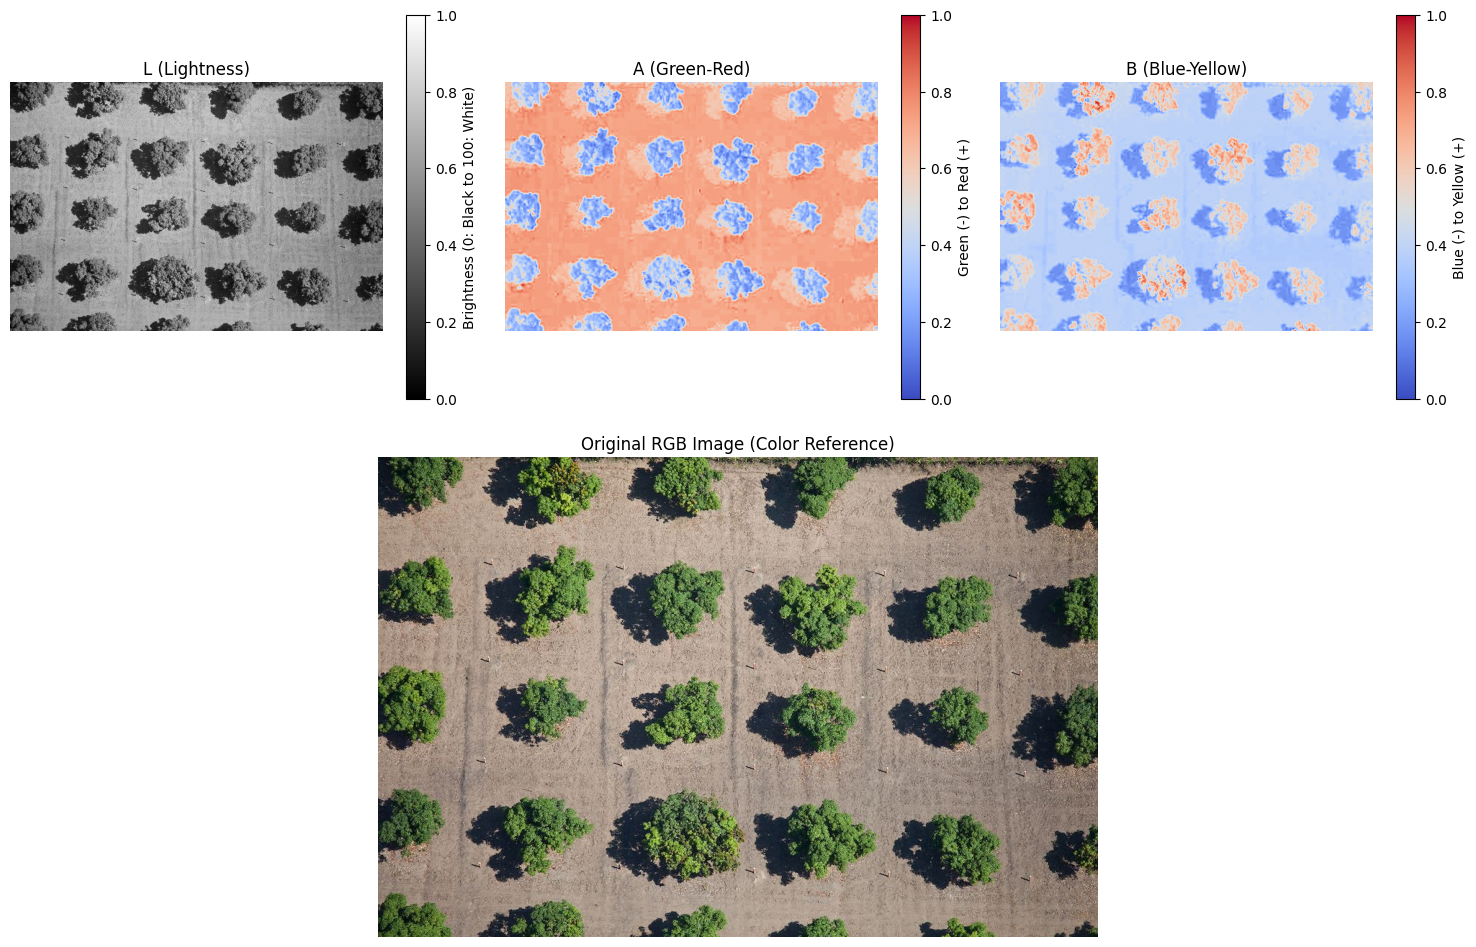

In [24]:
lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
L, A, B = cv2.split(lab_image)

# Set up the grid layout using gridspec
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, height_ratios=[1, 1])  # Equal height for both rows

# First Row: LAB Channels
# L (Lightness)
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(L, cmap='gray')
ax1.set_title("L (Lightness)")
ax1.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=ax1, shrink=0.8)
cbar.set_label("Brightness (0: Black to 100: White)")

# A (Green-Red)
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(A, cmap='coolwarm')
ax2.set_title("A (Green-Red)")
ax2.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=ax2, shrink=0.8)
cbar.set_label("Green (-) to Red (+)")

# B (Blue-Yellow)
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(B, cmap='coolwarm')
ax3.set_title("B (Blue-Yellow)")
ax3.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=ax3, shrink=0.8)
cbar.set_label("Blue (-) to Yellow (+)")

# Second Row: Original Image in Color
ax4 = fig.add_subplot(gs[1, :])  # Span all columns in the second row
ax4.imshow(image)
ax4.set_title("Original RGB Image (Color Reference)")
ax4.axis("off")

plt.tight_layout()
plt.show()

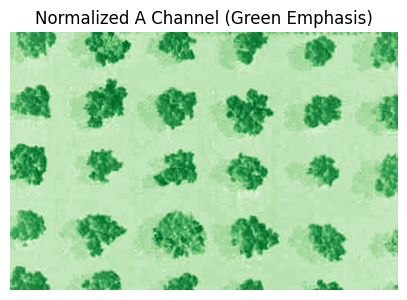

In [25]:
# Normalize the green-dominant range in the A channel
A_normalized = -A  # Flip to make green positive
A_normalized = (A_normalized - A_normalized.min()) / (A_normalized.max() - A_normalized.min())
# A_normalized = -A  # Flip to make green positive

# Visualize normalized green emphasis
plt.figure(figsize=(5, 4))
plt.imshow(A_normalized, cmap='Greens')
plt.title("Normalized A Channel (Green Emphasis)")
plt.axis("off")
plt.show()


### Vegetation Indices

- **ExG:** Excess Green Index 
- **GLI:** Green Leaf Index
- **NDI:** Normalized Difference Index
    - Also referred to as **GRVI** (Green-Red Vegetation Index)
    - Highlights areas with strong green dominance over red.
    - Can be useful for identifying chlorophyll content.
- **VARI:** Visible Atmospherically Resistant Index
- **TVI:** Triangular Vegetation Index
    - Captures vegetation vigor through its triangular relationship.
    - Especially useful for robust vegetation assessments.

In [26]:
from plant_search.vegetation_indices import calculate_all_rgb_indices

# Calculate all indices
indices = calculate_all_rgb_indices(image)

# Prepare the indices and titles for plotting
index_titles = [
    ("Excess Green Index (ExG)", indices["ExG"]),
    ("Green Leaf Index (GLI)", indices["GLI"]),
    ("Normalized Difference Index (NDI)", indices["NDI"]),
    ("Visible Atmospherically Resistant Index (VARI)", indices["VARI"]),
    ("Triangular Vegetation Index (TVI)", indices["TVI"]),
]

# Set up the grid for three columns
n_cols = 3
n_rows = (len(index_titles) + n_cols - 1) // n_cols  # Compute rows based on the number of indices
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))

# Plot each index
for i, (title, index) in enumerate(index_titles):
    row, col = divmod(i, n_cols)
    axes[row, col].imshow(index, cmap='Greens')
    axes[row, col].set_title(title)
    axes[row, col].axis("off")

# Turn off unused subplots
for i in range(len(index_titles), n_rows * n_cols):
    row, col = divmod(i, n_cols)
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

### Histogram-Based Thresholding

Histogram-based thresholding is a widely used technique in image processing for segmenting an image into meaningful regions. It leverages the pixel intensity distribution (histogram) to determine an optimal threshold value that separates the foreground (objects of interest) from the background.

### How It Works:
1. **Pixel Intensity Distribution**:
   - A histogram represents the frequency of pixel intensities in the image, ranging from 0 (black) to 255 (white) for grayscale images.

2. **Manual Thresholding**:
   - The user selects a threshold value, and pixels are classified as foreground if their intensity is above the threshold, or background otherwise.

3. **Automatic Thresholding**:
   - Algorithms like **Otsu’s Method** compute an optimal threshold automatically by minimizing intra-class variance (the variance within the foreground and background).

4. **Binary Segmentation**:
   - The result is a binary mask where pixels are either 1 (foreground) or 0 (background), suitable for object detection and analysis.

**Advantages:**
- Simple to implement and computationally efficient.
- Works well when the foreground and background have distinct intensity distributions.

**Limitations:**
- Struggles with complex images where foreground and background intensities overlap.
- Sensitive to noise and uneven illumination.

**Applications:**
- Extracting objects from grayscale images.
- Preprocessing for computer vision tasks like edge detection and object recognition.


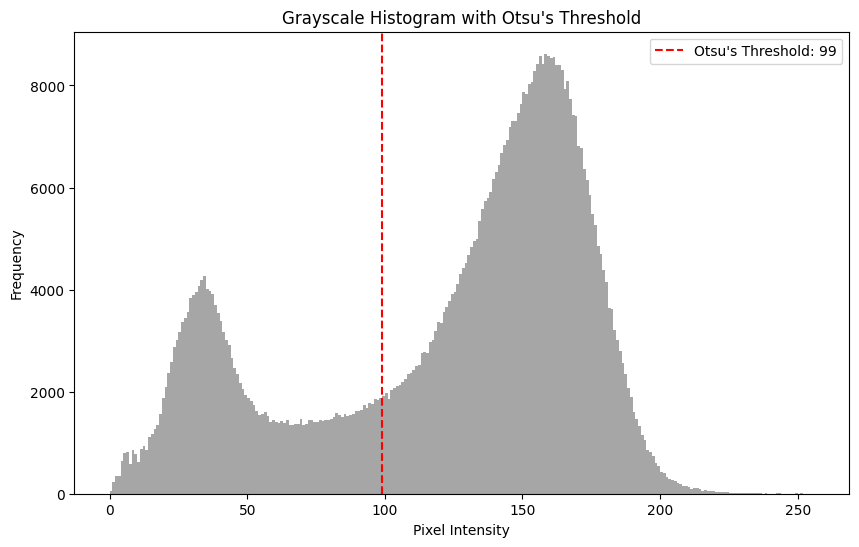

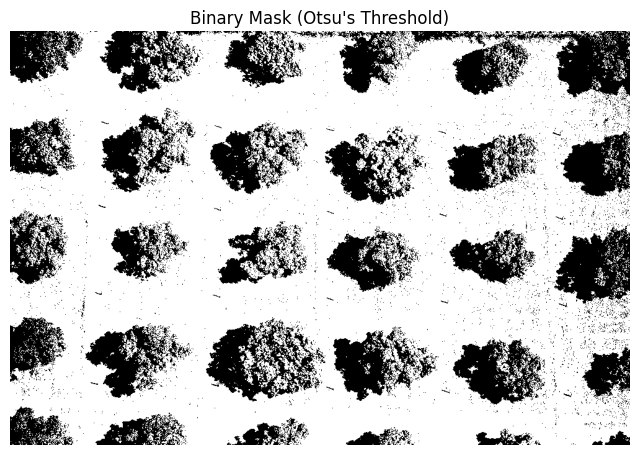

In [ ]:
from skimage.filters import threshold_otsu

# Convert the RGB image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Otsu's Method
otsu_threshold = threshold_otsu(gray_image)
binary_mask_otsu = gray_image > otsu_threshold

# Visualize the histogram and Otsu's threshold
plt.figure(figsize=(10, 6))
plt.hist(gray_image.ravel(), bins=256, range=(0, 256), color='gray', alpha=0.7)
plt.axvline(otsu_threshold, color='red', linestyle='--', label=f"Otsu's Threshold: {otsu_threshold}")
plt.title("Grayscale Histogram with Otsu's Threshold")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Visualize the binary mask
plt.figure(figsize=(8, 6))
plt.imshow(binary_mask_otsu, cmap='gray')
plt.title("Binary Mask (Otsu's Threshold)")
plt.axis("off")
plt.show()

### Texture-Based Analysis

#### Edge Detection

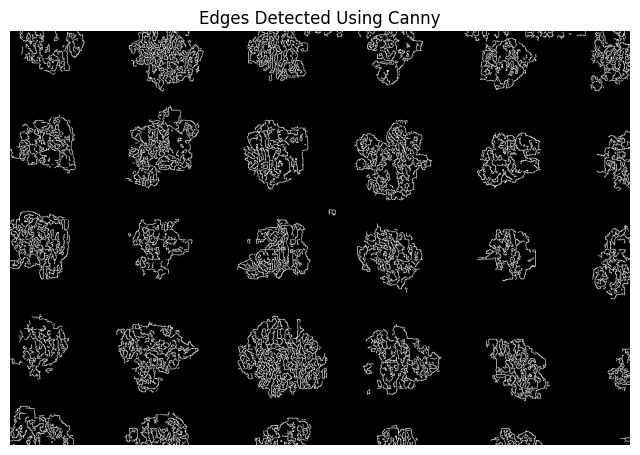

In [ ]:

# Convert the RGB image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Apply Canny edge detection
# edges = cv2.Canny(gray_image, threshold1=50, threshold2=150)

exg_normalized = cv2.normalize(indices["ExG"], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
exg_uint8 = exg_normalized.astype(np.uint8)  # Convert to uint8 format

edges = cv2.Canny(exg_uint8, threshold1=50, threshold2=150)

# Visualize edges
plt.figure(figsize=(8, 6))
plt.imshow(edges, cmap='gray')
plt.title("Edges Detected Using Canny")
plt.axis("off")
plt.show()


In [ ]:

# Interactive function
def interactive_canny_and_mask(threshold1, threshold2, veg_threshold):
    """
    Perform Canny edge detection on a vegetation index and combine with a binary mask.
    
    Parameters:
    - threshold1: Lower threshold for Canny.
    - threshold2: Upper threshold for Canny.
    - veg_threshold: Threshold for vegetation index binary mask.
    """
    # Normalize and process ExG
    exg_normalized = cv2.normalize(indices["ExG"], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    exg_uint8 = exg_normalized.astype(np.uint8)

    # Apply Canny edge detection
    edges = cv2.Canny(exg_uint8, threshold1=threshold1, threshold2=threshold2)

    # Create binary mask for vegetation index
    binary_mask = exg_normalized > veg_threshold

    # Combine edges and binary mask
    combined_mask = edges.astype(bool) | binary_mask

    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Canny edges
    axes[0].imshow(edges, cmap='Greens')
    axes[0].set_title("Canny Edges")
    axes[0].axis("off")

    # Binary vegetation mask
    axes[1].imshow(binary_mask, cmap='Greens')
    axes[1].set_title(f"Vegetation Mask (Threshold = {veg_threshold})")
    axes[1].axis("off")

    # Combined mask
    axes[2].imshow(combined_mask, cmap='Greens')
    axes[2].set_title("Combined Mask (Edges + Vegetation)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Create interactive sliders
interact(
    interactive_canny_and_mask,
    threshold1=IntSlider(value=50, min=0, max=255, step=1, description="Canny Thresh1"),
    threshold2=IntSlider(value=150, min=0, max=255, step=1, description="Canny Thresh2"),
    veg_threshold=FloatSlider(value=50, min=0, max=255, step=1, description="Veg Threshold")
);


interactive(children=(IntSlider(value=50, description='Canny Thresh1', max=255), IntSlider(value=150, descript…

#### Local Texture Analysis (Entropy)

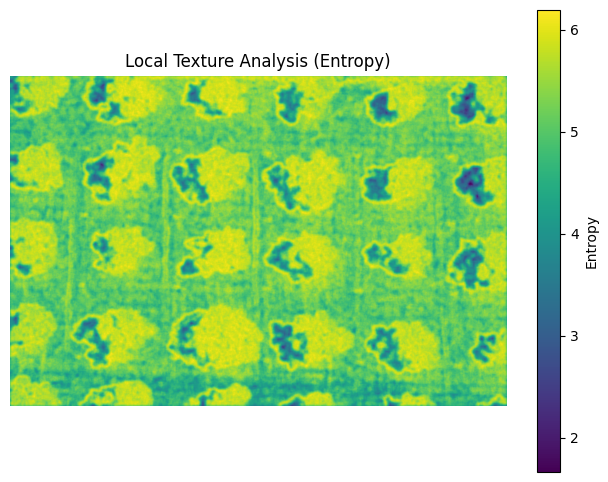

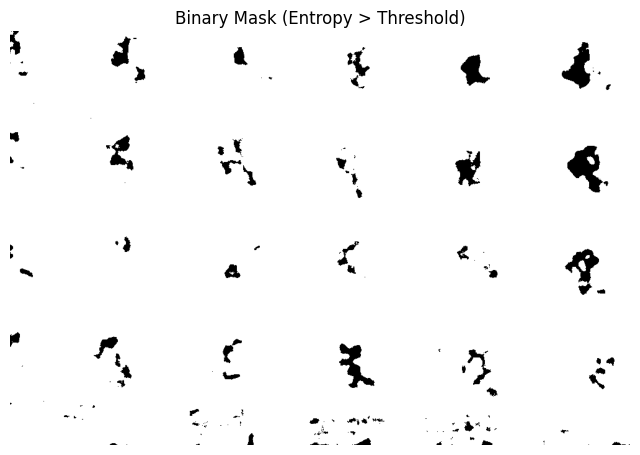

In [ ]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

# Calculate entropy using a disk-shaped neighborhood
entropy_image = entropy(gray_image, disk(5))  # Adjust disk size for larger/smaller neighborhoods

# Visualize entropy
plt.figure(figsize=(8, 6))
plt.imshow(entropy_image, cmap='viridis')
plt.colorbar(label="Entropy")
plt.title("Local Texture Analysis (Entropy)")
plt.axis("off")
plt.show()

# Threshold the entropy to create a binary mask
entropy_threshold = 4.0  # Adjust threshold based on the image
binary_mask_entropy = entropy_image > entropy_threshold

# Visualize the binary mask
plt.figure(figsize=(8, 6))
plt.imshow(binary_mask_entropy, cmap='gray')
plt.title("Binary Mask (Entropy > Threshold)")
plt.axis("off")
plt.show()


### Clustering

#### K-Means Clustering

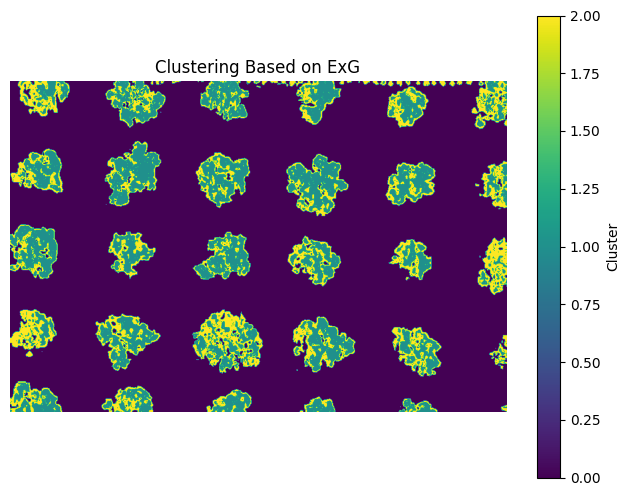

In [ ]:
from sklearn.cluster import KMeans

# Reshape image or vegetation index for clustering
def prepare_data_for_clustering(image, use_index=None):
    """
    Prepare data for clustering.

    Parameters:
    - image: RGB image (H, W, 3).
    - use_index: Vegetation index to use for clustering (e.g., "ExG", "GLI", None for RGB).

    Returns:
    - reshaped_data: Data reshaped to (N, features) for clustering.
    - original_shape: Shape of the original image.
    """
    if use_index is None:
        # Use RGB values for clustering
        reshaped_data = image.reshape(-1, 3)
    else:
        # Use vegetation index
        index_data = indices[use_index]
        reshaped_data = index_data.flatten().reshape(-1, 1)  # Single feature (index)
    return reshaped_data, image.shape[:2]

# Apply k-means clustering
def apply_kmeans_clustering(data, n_clusters=3):
    """
    Apply k-means clustering to the prepared data.

    Parameters:
    - data: Data prepared for clustering (N, features).
    - n_clusters: Number of clusters.

    Returns:
    - Cluster labels for each data point.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    return labels

# Visualize clustered image
def visualize_clusters(labels, shape, title="Clustering Result"):
    """
    Visualize clustering result.

    Parameters:
    - labels: Cluster labels for each pixel (flattened).
    - shape: Original image shape for reshaping.
    - title: Title for the plot.
    """
    clustered_image = labels.reshape(shape)
    plt.figure(figsize=(8, 6))
    plt.imshow(clustered_image, cmap='viridis')
    plt.title(title)
    plt.axis("off")
    plt.colorbar(label="Cluster")
    plt.show()

# Example: Use ExG for clustering
data, original_shape = prepare_data_for_clustering(image, use_index="ExG")
cluster_labels = apply_kmeans_clustering(data, n_clusters=3)
visualize_clusters(cluster_labels, original_shape, title="Clustering Based on ExG")


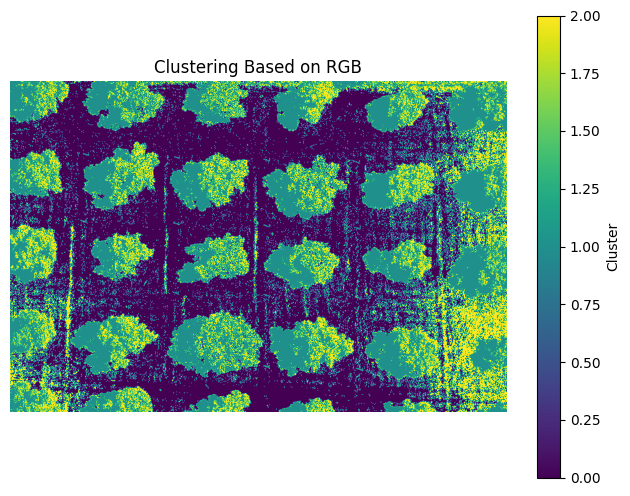

In [ ]:
data, original_shape = prepare_data_for_clustering(image)
cluster_labels = apply_kmeans_clustering(data, n_clusters=3)
visualize_clusters(cluster_labels, original_shape, title="Clustering Based on RGB")


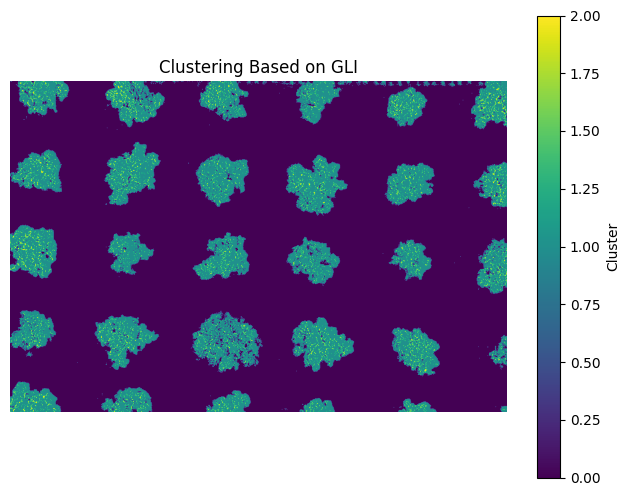

In [ ]:
data, original_shape = prepare_data_for_clustering(image, use_index="GLI")
cluster_labels = apply_kmeans_clustering(data, n_clusters=3)
visualize_clusters(cluster_labels, original_shape, title="Clustering Based on GLI")


In [ ]:
from ipywidgets import interact, IntSlider

def interactive_clustering(n_clusters):
    cluster_labels = apply_kmeans_clustering(data, n_clusters=n_clusters)
    visualize_clusters(cluster_labels, original_shape, title=f"Clustering with {n_clusters} Clusters")

interact(interactive_clustering, n_clusters=IntSlider(value=3, min=2, max=10, step=1, description="Clusters"))


interactive(children=(IntSlider(value=3, description='Clusters', max=10, min=2), Output()), _dom_classes=('wid…

<function __main__.interactive_clustering(n_clusters)>

#### Gaussian Mixture Models (GMM)

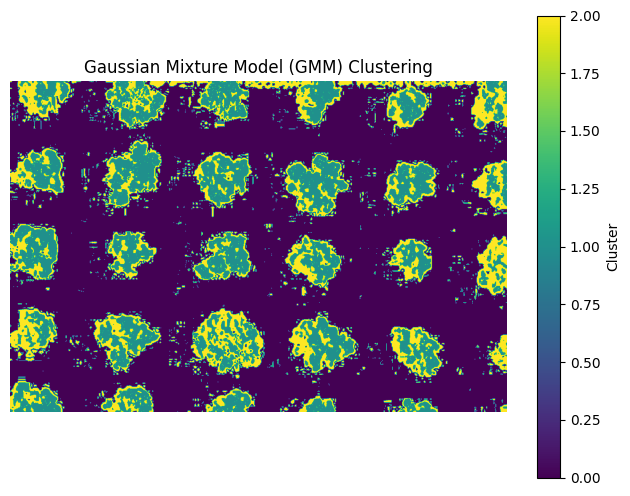

In [ ]:
from sklearn.mixture import GaussianMixture

# Apply Gaussian Mixture Model
def apply_gmm_clustering(data, n_components=3):
    """
    Apply Gaussian Mixture Model (GMM) clustering.

    Parameters:
    - data: Data prepared for clustering (N, features).
    - n_components: Number of Gaussian components (clusters).

    Returns:
    - Cluster labels for each data point.
    """
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    labels = gmm.fit_predict(data)
    return labels

# Example: Use ExG for GMM clustering
data, original_shape = prepare_data_for_clustering(image, use_index="ExG")
gmm_labels = apply_gmm_clustering(data, n_components=3)
visualize_clusters(gmm_labels, original_shape, title="Gaussian Mixture Model (GMM) Clustering")


#### DBSCAN (Density-Based Spatial Clustering)

DO NOT RUN THIS FOR ANY REASON
COMPLETELY WIPES YOUR RAM
WELCOME TO SWAP SPACE

In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN Clustering
def apply_dbscan_clustering(data, eps=0.05, min_samples=10):
    """
    Apply DBSCAN clustering.

    Parameters:
    - data: Data prepared for clustering (N, features).
    - eps: Maximum distance between two samples for them to be considered as neighbors.
    - min_samples: Minimum number of points in a neighborhood to form a cluster.

    Returns:
    - Cluster labels for each data point.
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    return labels

# Example: Use ExG for DBSCAN clustering
data, original_shape = prepare_data_for_clustering(image, use_index="ExG")
dbscan_labels = apply_dbscan_clustering(data, eps=0.12, min_samples=5)
visualize_clusters(dbscan_labels, original_shape, title="DBSCAN Clustering")
